In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Dropout

In [107]:
file_path = 'CountryFactorData.csv'
dataset = pd.read_csv(file_path)
dataset['Date'] = pd.to_datetime(dataset['Date'])
df = dataset[(dataset['Date'] < "2024-01-01") * (dataset['Date'] > "2000-04-01")].ffill()
df = df[df['Ticker'] != 'MXRU']

In [108]:
encoder = OneHotEncoder()
ticker_encoded = encoder.fit_transform(df[['Ticker']])
ticker_encoded.toarray()

df_encoded = df.reset_index(drop = True).join(pd.DataFrame(ticker_encoded.toarray()), how = 'left')
df_encoded = df_encoded.drop(columns = ['Ticker', 'Price', '1M_Simple_Ret', '1Y Beta', '1M_Log_Ret'])
df_encoded

,Date,Size,Value,Momentum,Market Risk Premium,3M_Log_Ret,0,1,2,3,...,33,34,35,36,37,38,39,40,41,42
0,2023-12-31,5.333921e+04,0.9576,1.0133,0.1509,0.002917,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-12-31,1.328736e+06,2.2664,0.6311,0.1509,-0.007560,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-12-31,2.590131e+05,1.5868,0.9700,0.1509,0.015294,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-12-31,7.108325e+05,1.7010,1.0866,0.1509,-0.089118,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-12-31,2.193971e+06,1.9414,0.9683,0.1509,0.034200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12250,2000-04-30,3.822681e+03,2.1521,0.8995,0.0645,-0.448124,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12251,2000-04-30,3.822681e+03,8.0402,2.1571,0.0645,-0.342948,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12252,2000-04-30,3.822681e+03,4.4785,1.5091,0.0645,-0.085384,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12253,2000-04-30,8.992112e+06,5.1140,1.1515,0.0645,-0.023980,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [109]:
# Split the data into training and testing sets
test_train_split_date = '2020-01-01'

In [110]:
df_train = df_encoded[df_encoded['Date'] < test_train_split_date]
df_test = df_encoded[df_encoded['Date'] >= test_train_split_date]

In [111]:
# Separate input factors (X) and returns (y)
X_train = df_train.drop(columns = ['3M_Log_Ret', 'Date'])  # Assuming 'returns' is the column name for the target variable
y_train = 1 * (df_train['3M_Log_Ret'] > df_train['3M_Log_Ret'].mean())
#y_train = y_train.reshape((len(y_train), 1, 3))

X_test = df_test.drop(columns = ['3M_Log_Ret', 'Date'])  # Assuming 'returns' is the column name for the target variable
y_test = 1 * (df_test['3M_Log_Ret'] > df_test['3M_Log_Ret'].mean())
#y_test= y_test.reshape((len(y_test), 1, 3))

# Standardize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for RNN (samples, timesteps, features)
# Assuming we treat each row as a single time step, and each feature as a separate input
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the NN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation = 'sigmoid')  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [112]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Make predictions
predictions = model.predict(X_test_reshaped)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [113]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_reshaped, y_test, verbose=0)
print("Test Loss, Test Accuracy:", loss)

Test Loss, Test Accuracy: [0.838557779788971, 0.5247092843055725]


In [114]:
first_third, second_third = df_train['3M_Log_Ret'].quantile([0.33, 0.67])

In [115]:
# Separate input factors (X) and returns (y)
X_train = df_train.drop(columns = ['3M_Log_Ret', 'Date'])  # Assuming 'returns' is the column name for the target variable
y_train = np.array(tf.keras.utils.to_categorical(
    np.where((df_train['3M_Log_Ret'] < first_third), 0, np.where(df_train['3M_Log_Ret'] < second_third, 1, 2)),
    num_classes = 3).tolist())
y_train = y_train.reshape((len(y_train), 1, 3))

X_test = df_test.drop(columns = ['3M_Log_Ret', 'Date'])  # Assuming 'returns' is the column name for the target variable
y_test = tf.keras.utils.to_categorical(
    np.where((df_test['3M_Log_Ret'] < first_third), 0, np.where(df_test['3M_Log_Ret'] < second_third, 1, 2)),
    num_classes = 3)
y_test= y_test.reshape((len(y_test), 1, 3))

# Standardize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for RNN (samples, timesteps, features)
# Assuming we treat each row as a single time step, and each feature as a separate input
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the NN model
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(3, activation = 'softmax')  # Output layer with a single neuron for regression
])

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [116]:
# Train the model
model1.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Make predictions
predictions = model1.predict(X_test_reshaped)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [117]:
# Evaluate the model on the test set
loss = model1.evaluate(X_test_reshaped, y_test, verbose=0)
print("Test Loss, Test Accuracy:", loss)

Test Loss, Test Accuracy: [1.264121651649475, 0.36240309476852417]


In [118]:
df = df[df['Date'] > test_train_split_date]

tickers = df['Ticker'].unique().tolist()
weight = 10000 / len(tickers)
df_backtest = df.copy(deep = True)

df_backtest['cur_amount'] = weight / df['Price']
df_backtest['next_amount'] = df_backtest['cur_amount'] * (1 + df_backtest['1M_Simple_Ret'])
df_backtest['profit'] = df_backtest['next_amount'] - df_backtest['cur_amount']
df_backtest_grouped = df_backtest.groupby('Date')[['profit']].sum()

In [119]:
def backtest_strategy(model, validator):
    df_strategy = df.copy(deep = True)
    df_temp = df[['Ticker', 'Size', 'Value', 'Momentum', 'Market Risk Premium']]

    ticker_encoded = encoder.fit_transform(df_temp[['Ticker']])
    ticker_encoded.toarray()

    df_encoded = df_temp.reset_index(drop = True).join(pd.DataFrame(ticker_encoded.toarray()), how = 'left')
    df_encoded = df_encoded.drop(columns = ['Ticker'])

    X_train_scaled_iter = scaler.fit_transform(df_encoded)
    X_train_reshaped_iter = X_train_scaled_iter.reshape((X_train_scaled_iter.shape[0], 1, X_train_scaled_iter.shape[1]))

    predictions = model.predict(X_train_reshaped_iter, verbose = 0)

    buys = np.zeros(len(X_train_reshaped_iter))
    count = 0

    for prediction in predictions:
        #print(prediction.flatten()[0])
        #break
        
        if validator(prediction.flatten()):
            buys[count] = 1
        count = count + 1

    df_strategy['Signal'] = buys
    amount_rebal = 10000 / df_strategy[['Date', 'Signal']].groupby('Date').sum()

    df_strategy_backtest = df_strategy.merge(amount_rebal, left_on = 'Date', right_index = True, how = 'left', suffixes = ['', '_amount'])

    df_strategy_backtest['cur_amount'] = (df_strategy_backtest['Signal_amount'] / df_strategy_backtest['Price']) * df_strategy_backtest['Signal']
    df_strategy_backtest['next_amount'] = df_strategy_backtest['cur_amount'] * (1 + df_strategy_backtest['1M_Simple_Ret'])
    df_strategy_backtest['profit'] = df_strategy_backtest['next_amount'] - df_strategy_backtest['cur_amount']

    df_strategy_grouped = df_strategy_backtest.groupby('Date')[['profit']].sum()
    
    return df_strategy_grouped

In [120]:
df_strategy1 = backtest_strategy(model, lambda x : x[0] >= 0.65)
df_strategy2 = backtest_strategy(model1, lambda x : np.argmax(x) == 2)

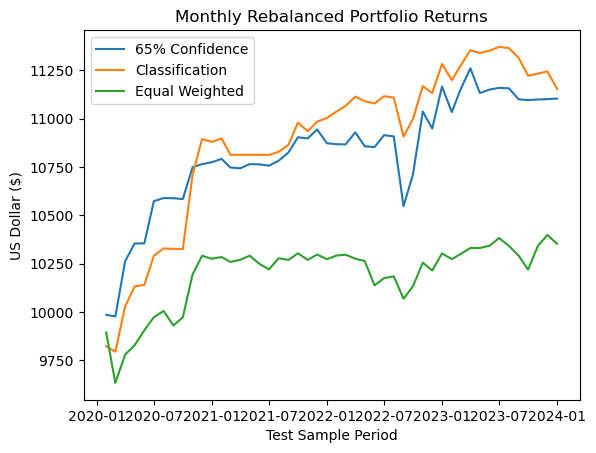

In [121]:
mp.plot(df_strategy1['profit'].cumsum() + 10000, label = "65% Confidence")
mp.plot(df_strategy2['profit'].cumsum() + 10000, label = 'Classification')
mp.plot(df_backtest_grouped['profit'].cumsum() + 10000, label = 'Equal Weighted')
mp.title("Monthly Rebalanced Portfolio Returns")
mp.ylabel("US Dollar ($)")
mp.xlabel("Test Sample Period")
mp.legend()